In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/data/home/marmot/camtrap/PyCharm/CameraTraps-benchmark')

In [3]:
import json
import os
from collections import OrderedDict, defaultdict, Counter
from copy import deepcopy
from random import sample
from statistics import mean, median
import math

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm

from data_management.cct_json_utils import CameraTrapJsonUtils, IndexedJsonDb
from visualization.visualization_utils import plot_stacked_bar_chart, render_db_bounding_boxes, resize_image

## Size of bounding boxes

As a percentage of image size

In [4]:
def get_images_annotations(file_template):
    # combine train and val splits for the image databases
    all_images = []
    all_annotations = []

    for i in ('train', 'val'):
        with open(file_template.format(i)) as f:
            db = json.load(f)
        print('{} has {} images, {} annotations'.format(i, len(db['images']), len(db['annotations'])))
        all_images.extend(db['images'])
        all_annotations.extend(db['annotations'])

    print('In total there are {} images, {} annotations'.format(len(all_images), len(all_annotations)))
    
    db_indexed = IndexedJsonDb(db)  # assume both train and val have the same categories field
    
    return all_images, all_annotations, db_indexed

In [5]:
def get_box_size_proportion(all_images, all_annotations):
    image_to_size = {}
    for i in all_images:
        image_to_size[i['id']] = i['width'] * i['height']

    ave_size = mean(image_to_size.values())
    print('Average image size is {}. Square root of that is {}'.format(ave_size, math.sqrt(ave_size)))

    box_size_percent = []  # size of each box as a percentage of its image
    box_width_to_height = []
    for a in all_annotations:
        _, _, w, h = a['bbox']
        image_size = image_to_size[a['image_id']]
        percent = w * h / image_size
        box_size_percent.append(percent)
        
        box_width_to_height.append(w/h)
    return box_size_percent, box_width_to_height

In [6]:
def print_stats(array):
    print('\nmean', mean(array))
    print('median', median(array))
    print('min', min(array))
    print('max', max(array))

In [8]:
cct_file_template = '/beaver_disk/camtrap/caltech/benchmark/cct-20/caltech-20_bboxes_20190904_{}.json'
cct_images, cct_annotations, cct_db_indexed = get_images_annotations(cct_file_template)

train has 26460 images, 27644 annotations
val has 19566 images, 20459 annotations
In total there are 46026 images, 48103 annotations


In [9]:
cct_box_size_percent, cct_box_width_to_height = get_box_size_proportion(cct_images, cct_annotations)

print_stats(cct_box_size_percent)
print_stats(cct_box_width_to_height)

Average image size is 3119978.357971581. Square root of that is 1766.346047062008

mean 0.09858267356575082
median 0.02673092369477912
min 0.000381242571257343
max 1.0

mean 1.3002100231726141
median 1.2786512459658506
min 0.14572864321608067
max 13.040000000000001


In [10]:
ss1_file_template = '/beaver_disk/camtrap/ss_season1/benchmark/SnapshotSerengetiBboxesS01_20190903_{}.json'
ss1_images, ss1_annotations, ss1_db_indexed = get_images_annotations(ss1_file_template)

train has 9244 images, 14949 annotations
val has 3133 images, 4438 annotations
In total there are 12377 images, 19387 annotations


In [11]:
ss1_box_size_percent, ss1_box_width_to_height = get_box_size_proportion(ss1_images, ss1_annotations)

print_stats(ss1_box_size_percent)
print_stats(ss1_box_width_to_height)

Average image size is 3145728. Square root of that is 1773.6200269505302

mean 0.11397804474177163
median 0.03146632559195927
min 2.454770669994595e-05
max 0.9964217685390699

mean 1.397919769380166
median 1.2027269226826325
min 0.05100574915699493
max 14.026646204652389


## Plots

In [17]:
def plot_side_by_side_hist(series, names, num_bins=20, num_x_ticks=6, y_logscale=False):
    # each series is normalized by the number of items in each series
    totals = []
    for s in series:
        totals.append(len(s))
    
    weights = []
    for t in totals:
        series_weights = [1/t] * t  # t weights, each has value 1/t
        weights.append(series_weights)
    
    fig = plt.figure()
    ax = plt.subplot(111)

    n, bins, patches = ax.hist(series,
                             bins=num_bins,
                             weights=weights,
                             label=names)

    ax.legend()
    ax.set_xlabel('Percent of image size')
    ax.set_ylabel('Percent of instances')

    # https://stackoverflow.com/questions/31357611/format-y-axis-as-percent
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))  
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  
    
    # https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(num_x_ticks))
    
    if y_logscale:
        ax.set_yscale('log')
    return fig

Number of CCT boxes: 48103
Number of SS1 boxes: 19387


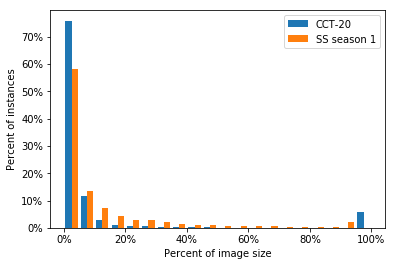

In [18]:
cct_num_boxes = len(cct_box_size_percent)
ss1_num_boxes = len(ss1_box_size_percent)
print('Number of CCT boxes:', cct_num_boxes)
print('Number of SS1 boxes:', ss1_num_boxes)

names = ['CCT-20', 'SS season 1']
series = [cct_box_size_percent, ss1_box_size_percent]

fig = plot_side_by_side_hist(series, names, y_logscale=False)

In [19]:
fig.savefig('/home/marmot/camtrap/mnt/intermediate/dataset_paper/bbox_dist.svg', 
            format='svg', bbox_inches='tight')

## Zoom in to the smallest boxes

In [14]:
percent_threshold = 0.1

cct_small = []
ss1_small = []

for c in cct_box_size_percent:
    if c < percent_threshold:
        cct_small.append(c)

for s in ss1_box_size_percent:
    if s < percent_threshold:
        ss1_small.append(s)

len(cct_small)
len(ss1_small)

42157

13837

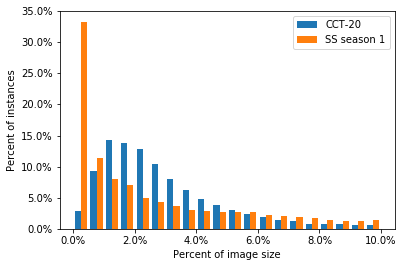

In [23]:
series_small = [cct_small, ss1_small]

fig_small = plot_side_by_side_hist(series_small, names, num_bins=20, num_x_ticks=6, y_logscale=False)

In [24]:
fig_small.savefig('/home/marmot/camtrap/mnt/intermediate/dataset_paper/bbox_small_dist.svg', 
            format='svg', bbox_inches='tight')

### CCT small boxes
There are no *tiny* boxes in CCT like the distant animals in SS.

In [66]:
area_threshold_pixels = 400
small_boxes = []

for a in tqdm(cct_annotations):
    _, _, w, h = a['bbox']
    area = w * h
    if area < area_threshold_pixels:
        small_boxes.append(a)
len(small_boxes)

100%|██████████| 48103/48103 [00:00<00:00, 1328915.48it/s]


0

In [67]:
0.02 * 3119978 # 2% of average size of images in CCT-20 - still quite large

62399.56

In [68]:
math.sqrt(62399)

249.79791832599406